<Figure size 640x480 with 0 Axes>

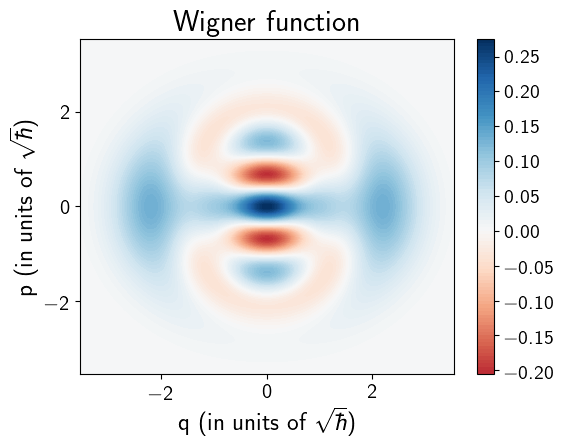

In [5]:
from qutip import *
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import math
from matplotlib import rc

scale = 1.2
sizeOfFont = scale*15
fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
     'size' : sizeOfFont}
rc('text', usetex=True)
rc('font',**fontProperties)
rc('text.latex', preamble=r'\usepackage{sansmathfonts}')

# Increasing the resolution of the plot
plt.figure(dpi=100)

# Ideal binomial codewords
def bincode(N, K,mu):
    return sum(np.sqrt(math.comb(K, i)/2**K) *((-1)**(i*mu)) * basis(K*N, i*N) for i in range(0,K,1))

# Fix binomial code parameters
Kval = 3
Nval = 2  
muval = 0 # 0 menas logical plus state

# Input
psi1 = bincode(Nval, Kval, muval)
psi2 = basis(Nval*Kval, 0)

#Beamsplitter


#Plot
limi = 3.54
rang = 100 
xvec = np.linspace(-limi, limi, rang)

W = wigner(psi1, xvec, xvec)

nrm = mpl.colors.Normalize(-W.max(), W.max())

fig, axes = plt.subplots(1, 1, figsize=(scale*5,scale*4))

plt1 = axes.contourf(xvec, xvec, W, 100, cmap=cm.RdBu, norm=nrm)

axes.set_title(f"Wigner function of Ideal")

plt.title("Wigner function")
plt.xlabel(f'q (in units of  $\sqrt\hbar$)')
plt.ylabel(f'p (in units of  $\sqrt\hbar$)')
colorBar = fig.colorbar(plt1, ax=axes)
ticklabs = colorBar.ax.tick_params(labelsize = scale*12)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig.tight_layout()

plt.show()